# Ray - a Python framework for distributed computation

Definition of a distributed system: 

_"Where a computer that you never heard of can bring your system down"_ -- Leslie Lamport

Distributed systems are necessary for many reasons: avoiding a single point of failure, distributing work to responsible departments and improving scalability. 

#### Improve scalability
The most obvious reason for distributing computation, from the perspective of data scientists, is to increase the amount of computer power, memory and storage available to us in a single machine.

#### Use compute power more effeciently
Sometimes we inherit a set of machines with different capabilities. For example, your data may be stored on one machine and relevant or specialized libraries on a different computer. A distributed cluster can make more effecient decisions: such as moving a few bytes of library code to the machine with the data, rather than moving gigabytes of data to the compute machine.

#### Avoid single point of failure
One of the most important benefits of distributed computation is to avoid a single point of failure. The internet itself, being a network of networks, was created to avoid complete system failure in case of a nuclear attack.

Failure is not just limited to physical attacks (or mistakes). In the early days of the internet, it was common to say that the "internet routes around censorship." 

### Ray - a Python library which enables distributed computation

Rather than a theoretical explanation, we will install and work with a real-world distributed framework called Ray. Ray is a python specific framework with many high level components which make it easier to serve APIs, train models, share data, etc. We will look at one of these components, before digging a bit deeper into a lower level component.

First steps, let's make sure Ray is installed:

In [ ]:
!pip install "ray[all]"

The above command installs all the necessary libraries needed for Ray. Please note that in this notebook, we will be testing only a local version of Ray.

#### Distribute a simple function (or Ray Tasks)

In [ ]:
import ray
import socket
import os

ray.init(ignore_reinit_error=True) # <= This is where Ray attempts to connect to an existing cluster, or starts a local one

In [ ]:
@ray.remote # <= This decorator tells Ray that this function should be distributed
def multiply(x):
    return x * x

future1 = multiply.remote(1)
future2 = multiply.remote(2)
future3 = multiply.remote(3)

print(ray.get([future1, future2, future3]))

In [ ]:
future1

In [ ]:
@ray.remote 
def get_node_info(x):
    hostname = socket.gethostname()
    pid = os.getpid()
    return f"Host: {hostname}, Process ID: {pid}"

future1 = get_node_info.remote(1)
future2 = get_node_info.remote(2)
future3 = get_node_info.remote(3)

print(ray.get([future1, future2, future3]))

# https://docs.ray.io/en/latest/ray-overview/getting-started.html

### Detour 1: How can  a piece of logic be distributed?

I'm sure you can imagine sending an excel file full of data to a colleague. Perhaps sending a single record, containing student grades or client demographics an api call. But how do you send a function? 

In [ ]:
def test_function(name="Shahbaz"):
    return f"Hiya {name}!"

In [ ]:
test_function("Homer")

Notice that a function is an object that we can access:

In [ ]:
test_function

In [ ]:
x = test_function

In [ ]:
x("Homer")

We can view this function as just a bunch of bytes, using Python's built-in `pickle` library:

In [ ]:
import pickle

pickled_function = pickle.dumps(test_function)

In [ ]:
pickled_function

The "pickle" library _serializes_ code into a represetation. We use the text represetnation above for easier viewing of the content.
We can now _deserialize_ those bytes back into an executable function:

In [ ]:
test_function_deserialized = pickle.loads(pickled_function)

In [ ]:
test_function_deserialized("Homer")

**Important** Instead of `print`ing the text, we just as easily could have sent it off to one of the worker nodes!

### Detour 2: What are futures?

The concept of a _future_ (and the related topic of a _promise_) is becoming more and more common in distributed and asynchronous computing. This concept is not limited to Python, in fact, their history goes back to a version of the LISP langauge. 

Futures simplify code by abstracting away an important detail in distributed computing: computation is running on a different machine, hence can be parallelized, while the code looks like it is executing in a serial manner.

Imagine this scenario:

In [ ]:
def heavy_computation(x):
    return x * x * x * x * x # ... some complicated operation which takes a long time to compute

answer1 = heavy_computation(100)
answer2 = heavy_computation(200)
answer3 = heavy_computation(300)

Imagine that `heavy_computation` actually is a very computationally heavy function. As we execute `heavy_computation`, our computer cpu usage shoots up and no other work can be done until the function has finished. We execute the three functions one at a time.

Now a different scenario

In [ ]:
def heavy_remote_computation(x):
    return x * x * x * x * x # ... some complicated operation which takes a long time to compute

answer1 = heavy_remote_computation(100)
answer2 = heavy_remote_computation(200)
answer3 = heavy_remote_computation(300)

Imagine that we are now doing the _same_ computation, but using a distributed framework to send these computations to remote machines.

Important difference: as `answer1` is being calculated, our local machine is doing NO work. It is simply waiting for the answer to be calculated on a worker node. **What is stopping us from sending some work to a worker node, then immediately sending more work to a different node?**

In other words, we can calculate answers 1, 2 and 3 in _parallel_!

Seerial execution

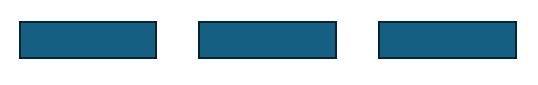

Parallel execution

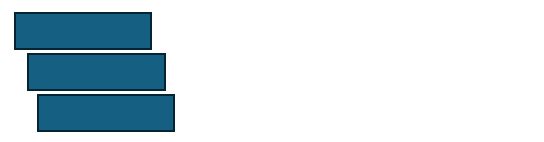

However, the code above becomes more complicated

```python
def heavy_remote_computation(x):
    return x * x * x * x * x # ... some complicated operation which takes a long time to compute

await_ans1 = execute_remote(heavy_remote_computation, 100) # serialize, send to remote worker, await result
await_ans2 = execute_remote(heavy_remote_computation, 200)
await_ans3 = execute_remote(heavy_remote_computation, 300)
```

Even this is not enough! If the whole point is that we shold execute all three commands in parallel, then what is actually being put into variables `answer1`, `answer2` and `answer3`?

**Futures** solve this problem. Python actually has TWO implementations of futures: `concurrent.futures.Future` and `asyncio.Future`. The implementation of the `Future` object is out of scope for this lecture. We will only look at the concept:

The word "future" here just means "the _future_ result of a computation." 

Some computations do not return the result of their computation right away. They return a place-holder object. This object remains empty, until the called function completes is work and the result is written to the future object. This is why ray has the `ray.get(..)` function. This function checks to see if the result has been calculated. If it has not, it _blocks_ (does not move forward). This is also why we don't call `ray.get()` right after calling the remote function. Calling `ray.get()` would defeat the purpose of futures!

#### Futures algebra
Note that future objects now exist in most languages and have their own algebra. For example, given multiple operations, a programmer can ask for things like:
 - get me the first future object that has results, ignore all others
 - either get me all results together or simply wait for them
 - only wait for X seconds, otherwise timeout
 - if a function results in an Exception, handle the exception
 - etc.

What's more, the concepts described here form the core of a modern (but unwelcomed by the author) trend of **async** or asynchronous computing.

To remind ourselves, here is the code again:

In [ ]:
@ray.remote # <= This decorator tells Ray that this function should be distributed
def multiply(x):
    return x * x

future1 = multiply.remote(1)
future2 = multiply.remote(2)
future3 = multiply.remote(3)

print(ray.get([future1, future2, future3]))

In [ ]:
type(future1)

### Distributing Python classes (or Ray Actors)

Ray extends the concept of distributed functions to distributed classes. Recall that classes not only have behavior (methods) but also state (variables which store values). Here is an example:

In [ ]:
@ray.remote
class Counter(object):
    def __init__(self):
        self.n = 0

    def increment(self):
        self.n += 1

    def read(self):
        return self.n

counters = [Counter.remote() for i in range(4)]
[c.increment.remote() for c in counters]
counters[1].increment.remote()
futures = [c.read.remote() for c in counters]
print(ray.get(futures)) # [1, 1, 1, 1]

# https://docs.ray.io/en/latest/ray-overview/getting-started.html

### Ray as a foundation layer
Ray is becoming a foundational layer for modern ML systes. Many other distributed frameworks now sit on top of Ray. For example, there are projects to distributed [Pandas on Ray](https://docs.ray.io/en/latest/ray-more-libs/modin/index.html), [Dask on Ray](https://docs.ray.io/en/latest/ray-more-libs/dask-on-ray.html), even [Spark on Ray](https://docs.ray.io/en/latest/ray-more-libs/raydp.html).

Ray is currently being used by cutting edge LLM companies:
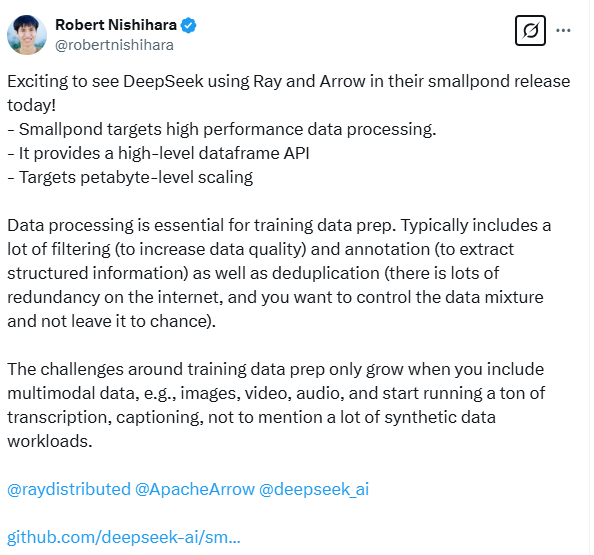

As data scientists, a sub-project of Ray, `Ray Serve` is what should be of practical interest foor us. See next notebook!